# Week 07 — Surrogate Models & Gaussian Processes

This notebook develops GP regression from first principles and applies it to surrogate-based optimisation:
- GP prior / posterior — mean function and covariance (kernel)
- From-scratch implementation vs sklearn `GaussianProcessRegressor`
- Kernel selection and log-marginal-likelihood
- Expected Improvement acquisition function
- Bayesian Optimisation loop applied to the 2D Branin benchmark function

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ExpSineSquared
%matplotlib inline

np.random.seed(42)
print('Libraries imported!')

Libraries imported!


In [ ]:
import os, pickle

CACHE_DIR = 'cache_week10'
os.makedirs(CACHE_DIR, exist_ok=True)

def save_result(key, obj):
    with open(os.path.join(CACHE_DIR, f'{key}.pkl'), 'wb') as f:
        pickle.dump(obj, f)

def load_result(key):
    path = os.path.join(CACHE_DIR, f'{key}.pkl')
    if os.path.exists(path):
        with open(path, 'rb') as f:
            return pickle.load(f)
    return None

def cached(key, compute_fn):
    result = load_result(key)
    if result is not None:
        print(f"[cache] loaded '{key}'")
        return result
    print(f"[cache] computing '{key}'...")
    result = compute_fn()
    save_result(key, result)
    return result

print('Cache utilities ready:', CACHE_DIR)

Cache utilities ready: cache_week07_gp


## 1. GP Prior — Samples from a Gaussian Process

A GP defines a distribution over functions.  
Before observing data the **prior** is characterised by:
- Mean function $m(x) = 0$ (by convention)
- Covariance / kernel $k(x, x') = \sigma^2 \exp\!\left(-\frac{(x-x')^2}{2\ell^2}\right)$ (RBF)

Evaluate the kernel at a grid of input points → covariance matrix → sample multivariate Gaussian.

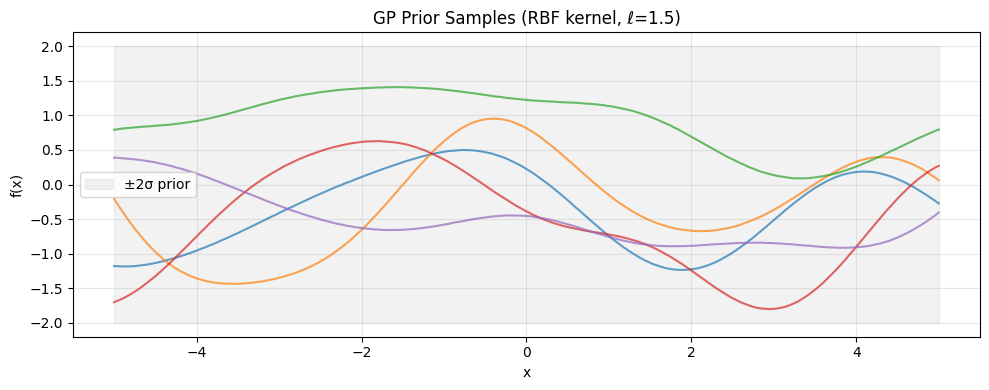

In [4]:
def rbf_kernel(X1, X2, length_scale=1.0, amplitude=1.0):
    """RBF / squared-exponential kernel."""
    sqdist = np.sum((X1[:, None] - X2[None, :]) ** 2, axis=-1)  # (n1, n2)
    return amplitude ** 2 * np.exp(-0.5 * sqdist / length_scale ** 2)


X_grid = np.linspace(-5, 5, 200)
K_prior = rbf_kernel(X_grid[:, None], X_grid[:, None], length_scale=1.5)
K_prior += 1e-6 * np.eye(len(X_grid))  # jitter for numerical stability

# Draw 5 prior samples
prior_samples = np.random.multivariate_normal(np.zeros(len(X_grid)), K_prior, size=5)

plt.figure(figsize=(10, 4))
for s in prior_samples:
    plt.plot(X_grid, s, alpha=0.7)
plt.fill_between(X_grid, -2, 2, alpha=0.1, color='gray', label='±2σ prior')
plt.title('GP Prior Samples (RBF kernel, ℓ=1.5)')
plt.xlabel('x'); plt.ylabel('f(x)'); plt.legend(); plt.grid(alpha=0.3)
plt.tight_layout(); plt.show()

## 2. GP Posterior — Closed-Form Derivation

Given $n$ observations $(\mathbf{X}, \mathbf{y})$ with noise $\sigma_n^2$, the posterior is:

$$\mu_* = K_* K^{-1} \mathbf{y}, \qquad \Sigma_* = K_{**} - K_* K^{-1} K_*^\top$$

where $K = k(\mathbf{X}, \mathbf{X}) + \sigma_n^2 I$, $K_* = k(\mathbf{X}, \mathbf{x}_*)$, $K_{**} = k(\mathbf{x}_*, \mathbf{x}_*)$.

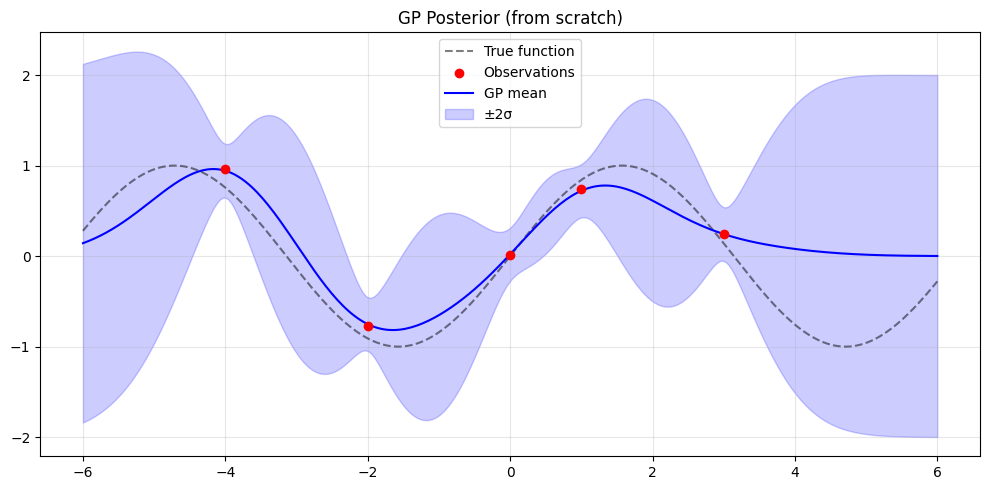

In [5]:
def gp_posterior(X_train, y_train, X_test, kernel_fn, sigma_n=0.1):
    """GP posterior mean and std via Cholesky decomposition."""
    K    = kernel_fn(X_train, X_train) + sigma_n ** 2 * np.eye(len(X_train))
    K_s  = kernel_fn(X_train, X_test)
    K_ss = kernel_fn(X_test,  X_test)
    L = np.linalg.cholesky(K + 1e-10 * np.eye(len(X_train)))
    alpha  = np.linalg.solve(L.T, np.linalg.solve(L, y_train))  # (X^T X)^{-1} y via Cholesky
    mu_s   = K_s.T @ alpha
    v      = np.linalg.solve(L, K_s)
    sigma2 = np.diag(K_ss) - np.einsum('ij,ij->j', v, v)
    return mu_s, np.sqrt(np.maximum(sigma2, 0))


# Noisy sine observations
def true_fn(x): return np.sin(x)

X_obs = np.array([-4, -2, 0, 1, 3])[:, None]
y_obs = true_fn(X_obs).ravel() + np.random.randn(len(X_obs)) * 0.15
X_test = np.linspace(-6, 6, 300)[:, None]

kernel = lambda X1, X2: rbf_kernel(X1, X2, length_scale=1.0)
mu, sigma = gp_posterior(X_obs, y_obs, X_test, kernel, sigma_n=0.15)

plt.figure(figsize=(10, 5))
plt.plot(X_test, true_fn(X_test), 'k--', alpha=0.5, label='True function')
plt.scatter(X_obs, y_obs, c='red', zorder=5, label='Observations')
plt.plot(X_test, mu, 'b-', label='GP mean')
plt.fill_between(X_test.ravel(), mu - 2*sigma, mu + 2*sigma,
                 alpha=0.2, color='blue', label='±2σ')
plt.title('GP Posterior (from scratch)')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

## 3. Comparison to sklearn GaussianProcessRegressor

[cache] loaded 'sklearn_gp_1d_sine'
sklearn GP optimised kernel: 0.637**2 * RBF(length_scale=0.413) + WhiteKernel(noise_level=0.0228)

Max |mu_ours - mu_sklearn|: 0.627317
(They differ slightly because sklearn optimises the kernel hypers — that is expected)


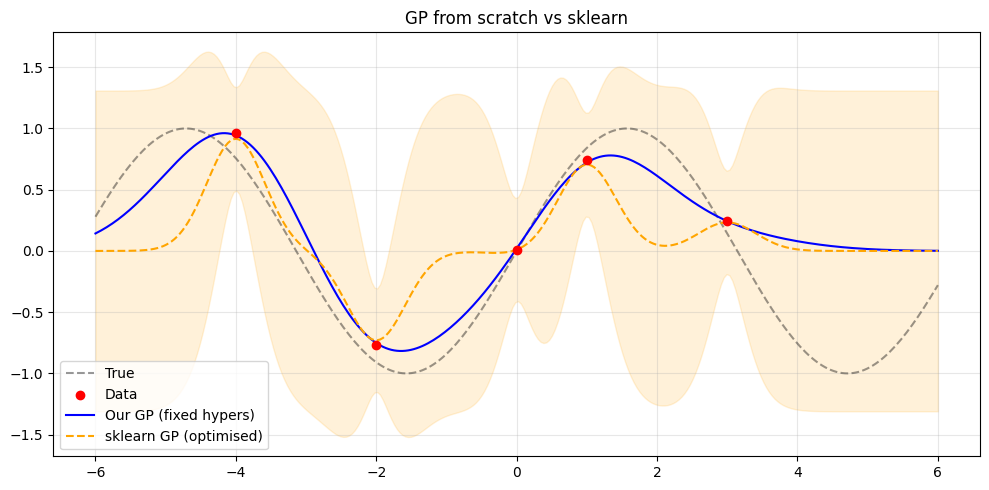

In [6]:
def _fit_sklearn_gp():
    sk_kernel = 1.0 * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.15**2)
    gpr = GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=5, random_state=42)
    gpr.fit(X_obs, y_obs)
    return gpr

gpr = cached('sklearn_gp_1d_sine', _fit_sklearn_gp)

mu_sk, sigma_sk = gpr.predict(X_test, return_std=True)
print('sklearn GP optimised kernel:', gpr.kernel_)
print(f'\nMax |mu_ours - mu_sklearn|: {np.max(np.abs(mu - mu_sk)):.6f}')
print('(They differ slightly because sklearn optimises the kernel hypers — that is expected)')

# Overlay comparison
plt.figure(figsize=(10, 5))
plt.plot(X_test, true_fn(X_test), 'k--', alpha=0.4, label='True')
plt.scatter(X_obs, y_obs, c='red', zorder=5, label='Data')
plt.plot(X_test, mu,    label='Our GP (fixed hypers)', color='blue')
plt.plot(X_test, mu_sk, label='sklearn GP (optimised)', color='orange', linestyle='--')
plt.fill_between(X_test.ravel(), mu_sk - 2*sigma_sk, mu_sk + 2*sigma_sk,
                 alpha=0.15, color='orange')
plt.legend(); plt.title('GP from scratch vs sklearn'); plt.grid(alpha=0.3)
plt.tight_layout(); plt.show()

## 4. Kernel Comparison & Log-Marginal-Likelihood

[cache] loaded 'kernel_comparison'


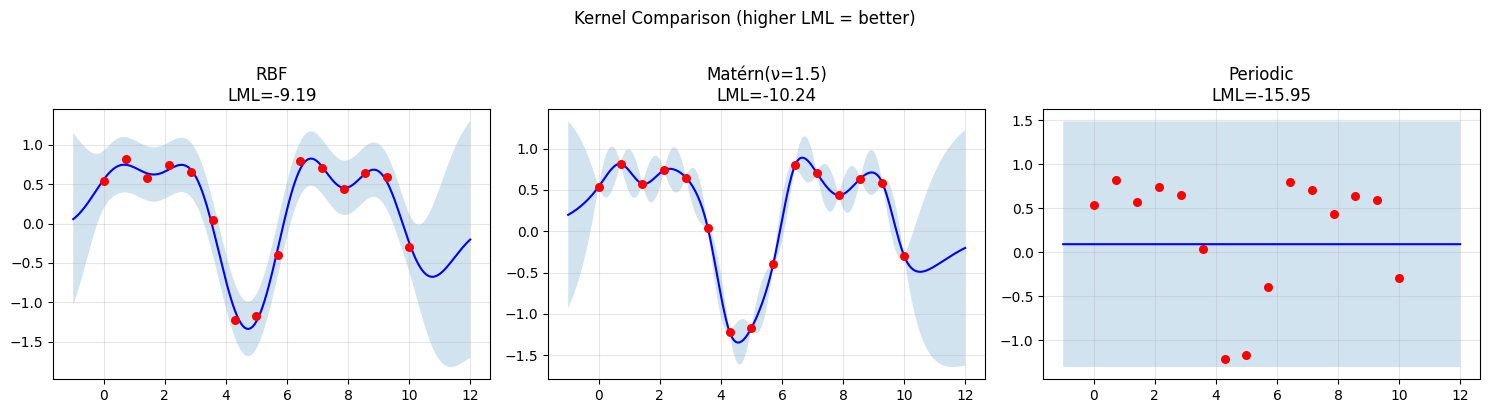

In [7]:
# Seasonal 1D test function
X_obs_s = np.linspace(0, 10, 15)[:, None]
y_obs_s = np.sin(X_obs_s).ravel() + 0.5*np.cos(2*X_obs_s).ravel() + 0.1*np.random.randn(15)
X_test_s = np.linspace(-1, 12, 200)[:, None]

kernels = {
    'RBF':              1.0 * RBF(length_scale=1.0) + WhiteKernel(1e-4),
    'Matérn(ν=1.5)':    1.0 * Matern(length_scale=1.0, nu=1.5) + WhiteKernel(1e-4),
    'Periodic':         1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0) + WhiteKernel(1e-4),
}

def _fit_kernel_comparison():
    fitted = {}
    for name, k in kernels.items():
        gpr_k = GaussianProcessRegressor(kernel=k, n_restarts_optimizer=3, random_state=42)
        gpr_k.fit(X_obs_s, y_obs_s)
        fitted[name] = gpr_k
    return fitted

fitted_kernels = cached('kernel_comparison', _fit_kernel_comparison)

fig, axes = plt.subplots(1, len(fitted_kernels), figsize=(15, 4))
for ax, (name, gpr_k) in zip(axes, fitted_kernels.items()):
    mu_k, sigma_k = gpr_k.predict(X_test_s, return_std=True)
    ax.scatter(X_obs_s, y_obs_s, c='red', zorder=5, s=30)
    ax.plot(X_test_s, mu_k, 'b-')
    ax.fill_between(X_test_s.ravel(), mu_k-2*sigma_k, mu_k+2*sigma_k, alpha=0.2)
    lml = gpr_k.log_marginal_likelihood(gpr_k.kernel_.theta)
    ax.set_title(f'{name}\nLML={lml:.2f}')
    ax.grid(alpha=0.3)
plt.suptitle('Kernel Comparison (higher LML = better)', y=1.02)
plt.tight_layout(); plt.show()

## 5. Expected Improvement Acquisition Function

Expected Improvement quantifies how much we *expect* a candidate $x$ to improve over the current best $f^*$:

$$\text{EI}(x) = (\mu(x) - f^* - \xi) \Phi(Z) + \sigma(x) \phi(Z), \quad Z = \frac{\mu(x) - f^* - \xi}{\sigma(x)}$$

EI = 0 when $\sigma = 0$ (already observed) and large when $\mu$ is high (exploitation) OR $\sigma$ is high (exploration).

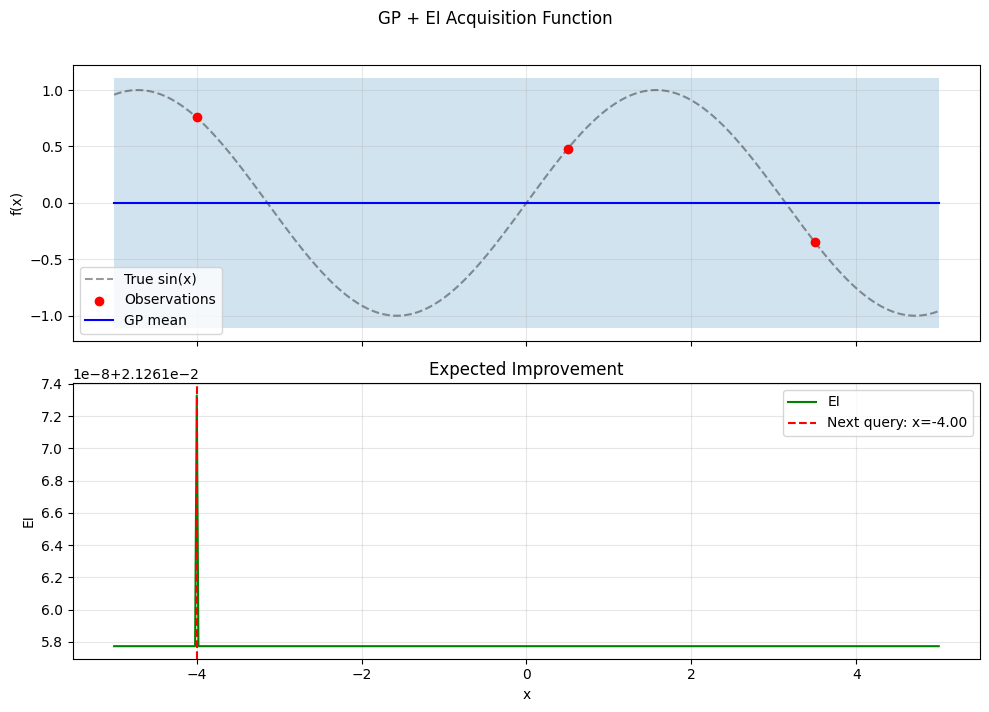

In [8]:
def expected_improvement(X_cand, gp, y_best, xi=0.01):
    """Closed-form Expected Improvement (maximisation convention)."""
    mu, sigma = gp.predict(X_cand, return_std=True)
    sigma = np.maximum(sigma, 1e-9)
    Z = (mu - y_best - xi) / sigma
    ei = (mu - y_best - xi) * norm.cdf(Z) + sigma * norm.pdf(Z)
    ei[sigma < 1e-9] = 0.0
    return ei


# 1D demo: find max of sin(x) in [-5, 5] with 3 random initial points
X_init = np.array([-4.0, 0.5, 3.5])[:, None]
y_init = np.sin(X_init).ravel()

gpr_demo = GaussianProcessRegressor(kernel=1.0 * RBF(1.0) + WhiteKernel(1e-5),
                                    n_restarts_optimizer=3, random_state=42)
gpr_demo.fit(X_init, y_init)
X_cands = np.linspace(-5, 5, 500)[:, None]
ei_vals = expected_improvement(X_cands, gpr_demo, y_best=y_init.max())

mu_d, sigma_d = gpr_demo.predict(X_cands, return_std=True)

fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
axes[0].plot(X_cands, np.sin(X_cands), 'k--', alpha=0.4, label='True sin(x)')
axes[0].scatter(X_init, y_init, c='red', zorder=5, label='Observations')
axes[0].plot(X_cands, mu_d, 'b-', label='GP mean')
axes[0].fill_between(X_cands.ravel(), mu_d-2*sigma_d, mu_d+2*sigma_d, alpha=0.2)
axes[0].set_ylabel('f(x)'); axes[0].legend(); axes[0].grid(alpha=0.3)
axes[1].plot(X_cands, ei_vals, 'g-', label='EI')
axes[1].axvline(X_cands[ei_vals.argmax(), 0], color='red', linestyle='--',
                label=f'Next query: x={X_cands[ei_vals.argmax(), 0]:.2f}')
axes[1].set_xlabel('x'); axes[1].set_ylabel('EI'); axes[1].legend(); axes[1].grid(alpha=0.3)
axes[1].set_title('Expected Improvement')
plt.suptitle('GP + EI Acquisition Function', y=1.01)
plt.tight_layout(); plt.show()

## 6. Bayesian Optimisation on the Branin Function

**Branin** is a standard 2D benchmark (3 global minima, irregular landscape):  
$f(x_1, x_2) = a(x_2 - bx_1^2 + cx_1 - r)^2 + s(1-t)\cos(x_1) + s$  
Global minimum $f(x^*) \approx 0.397$ achieved at roughly $(−\pi, 12.275)$, $(\pi, 2.275)$, $(9.42, 2.475)$.

[cache] loaded 'bayes_opt_branin'


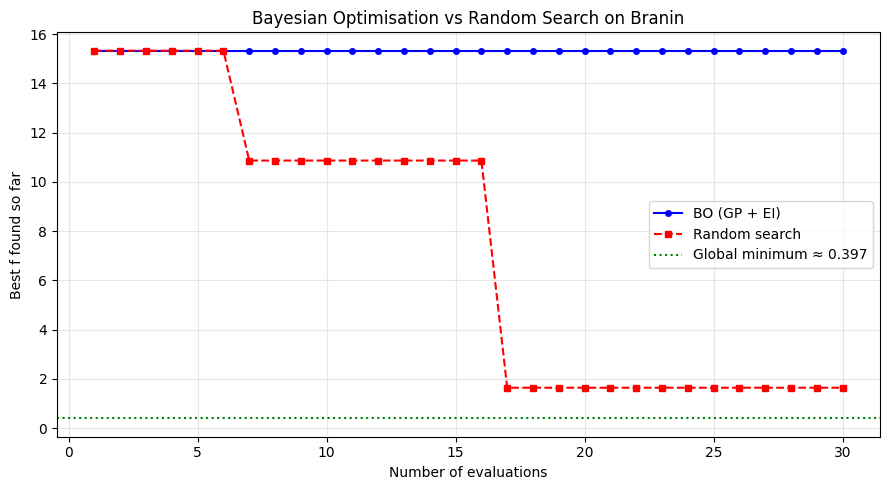

BO best:     15.3316
Random best: 1.6409
Global min:  0.397


In [9]:
def branin(x1, x2):
    """Branin-Hoo function. Global min ≈ 0.397."""
    a, b, c, r, s, t = 1, 5.1/(4*np.pi**2), 5/np.pi, 6, 10, 1/(8*np.pi)
    return a*(x2 - b*x1**2 + c*x1 - r)**2 + s*(1-t)*np.cos(x1) + s

# Budget: 30 evaluations total
def _run_bayes_opt():
    bounds = [(-5, 10), (0, 15)]
    n_init = 5
    budget = 30

    rng = np.random.default_rng(0)
    X_obs = rng.uniform([b[0] for b in bounds], [b[1] for b in bounds], size=(n_init, 2))
    y_obs = np.array([branin(*x) for x in X_obs])

    # Random baseline
    X_rand = rng.uniform([b[0] for b in bounds], [b[1] for b in bounds], size=(budget - n_init, 2))
    y_rand_all = np.append(y_obs, [branin(*x) for x in X_rand])
    random_trace = np.minimum.accumulate(y_rand_all)

    # BO trace
    bo_X = X_obs.copy()
    bo_y = y_obs.copy()
    gpr_bo = GaussianProcessRegressor(
        kernel=1.0 * Matern(nu=2.5) + WhiteKernel(noise_level=1e-4),
        n_restarts_optimizer=5, random_state=42, normalize_y=True)

    for _ in range(budget - n_init):
        gpr_bo.fit(bo_X, bo_y)
        # Maximise EI over a random grid (simple strategy)
        X_cands = rng.uniform([b[0] for b in bounds], [b[1] for b in bounds], size=(2000, 2))
        # Note: we MINIMISE f, so negate y for EI (assumes maximisation)
        ei = expected_improvement(X_cands, gpr_bo, y_best=-bo_y.min(), xi=0.01)
        x_next = X_cands[np.argmax(ei)]
        y_next = branin(*x_next)
        bo_X = np.vstack([bo_X, x_next])
        bo_y = np.append(bo_y, y_next)

    bo_trace = np.minimum.accumulate(bo_y)
    return bo_trace, random_trace

bo_trace, random_trace = cached('bayes_opt_branin', _run_bayes_opt)

plt.figure(figsize=(9, 5))
plt.plot(range(1, len(bo_trace)+1), bo_trace, 'b-o', markersize=4, label='BO (GP + EI)')
plt.plot(range(1, len(random_trace)+1), random_trace, 'r--s', markersize=4, label='Random search')
plt.axhline(0.397, color='green', linestyle=':', label='Global minimum ≈ 0.397')
plt.xlabel('Number of evaluations')
plt.ylabel('Best f found so far')
plt.title('Bayesian Optimisation vs Random Search on Branin')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

print(f'BO best:     {bo_trace[-1]:.4f}')
print(f'Random best: {random_trace[-1]:.4f}')
print(f'Global min:  0.397')

## Exercises

1. **GP from scratch vs sklearn** — run `gp_posterior` with fixed hypers and compare posterior mean to `sklearn.GaussianProcessRegressor` (with the same hypers, `optimizer=None`). Assert `np.allclose(atol=1e-4)`.
2. **Coverage check** — generate 1D ground-truth $f(x) = \sin(x)$ with noise 0.2; fit GP; check that ~95% of 200 test points fall inside the 95% credible interval.
3. **Kernel comparison** — reproduce the kernel comparison table from section 4 with a 5th kernel: `RBF + ExpSineSquared`.
4. **EI implementation** — implement UCB (Upper Confidence Bound) acquisition function; compare it to EI on the 1D sin demo.
5. **Branin with more budget** — extend BO to 50 evaluations; plot the 2D contour coloured by evaluation order to visualise the exploration/exploitation pattern.

In [10]:
# EXERCISE 1 — GP from scratch vs sklearn (fixed hypers)
# Goal: set optimizer=None, fixed_noise=True on GaussianProcessRegressor.
# Compare posterior mean arrays; assert np.allclose(mu_ours, mu_sklearn, atol=1e-4).

In [11]:
# EXERCISE 2 — Coverage check
# Goal: generate 50 training + 200 test points on sin; fit GP; count fraction inside ±2σ.
# Repeat 20 times with different seeds; report mean coverage fraction.
# Expected: ≈ 0.95 (within ~±0.03).

In [12]:
# EXERCISE 3 — Additional kernel
# Goal: add 'RBF + Periodic' to the kernel comparison in section 4.
# Report its LML; plot the fit.

In [13]:
# EXERCISE 4 — UCB acquisition function
# Goal: implement ucb(X_cand, gp, kappa=2.0) = mu + kappa * sigma.
# Plot UCB alongside EI on the 1D sin demo; annotate the next query for each.

In [14]:
# EXERCISE 5 — Branin exploration visualisation
# Goal: run BO for 50 evaluations; colour each evaluation point by iteration number.
# Overlay on a Branin contour plot. Observe: early points spread out (exploration),
# later points converge near the minimum (exploitation).